#  Spam Mail classification

In this notebook I have implemented classifiers (Naive Bayes and Support Vector Machines) to detect spam mails.

## Necessary libraries

In [1]:
import numpy as np
import pandas as pd
from collections import Counter

import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
from scikitplot.metrics import plot_confusion_matrix as plt_con_mat
import seaborn as sns

from sklearn import feature_extraction, model_selection, naive_bayes, metrics, svm

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Loading the Data

In [2]:
data = pd.read_csv("../input/sms-spam-collection-dataset/spam.csv", encoding='latin-1')
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


## Class distribution

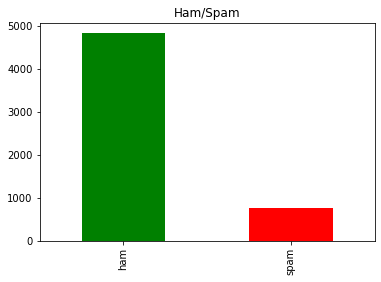

In [3]:
counts = pd.value_counts(data["v1"])
counts.plot(kind= 'bar', color= ['g', 'r'])
plt.title('Ham/Spam')
plt.show()

## Text preprocessing and feature engineering

In [4]:
clean_data = []

Y = np.array(data["v1"].map({'spam':1,'ham':0}))
Y = np.expand_dims(Y, axis = -1)

for doc in data["v2"]:
    
    killpunctuation = str.maketrans('', '', string.punctuation)
    lemmatizer = WordNetLemmatizer()
    
    text = doc.lower()
    text = text.translate(killpunctuation)
    text = text.split(' ')
    text = [lemmatizer.lemmatize(word) for word in text]
    text = (" ".join(text))
    clean_data.append(text)

tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_vectors = tfidf_vectorizer.fit_transform(clean_data)
X = tfidf_vectors.toarray()

print(X.shape, Y.shape)

(5572, 8679) (5572, 1)


## Splitting the Data into train and test sets

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, shuffle = True, test_size = 0.2, random_state = 1)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(4457, 8679) (4457, 1)
(1115, 8679) (1115, 1)


# Multinomial naive bayes classifier

In [6]:
alphas = np.arange(1/100000, 1, 0.001)
train_acc = []
test_acc = []
recall = []
precision = []

for alpha in alphas:
    
    bayes = naive_bayes.MultinomialNB(alpha = alpha)
    bayes.fit(X_train, y_train)
    
    train_acc.append(bayes.score(X_train, y_train))
    test_acc.append(bayes.score(X_test, y_test))
    recall.append(metrics.recall_score(y_test, bayes.predict(X_test)))
    precision.append(metrics.precision_score(y_test, bayes.predict(X_test)))
    
print("Training complete")

Training complete


## Model training performance

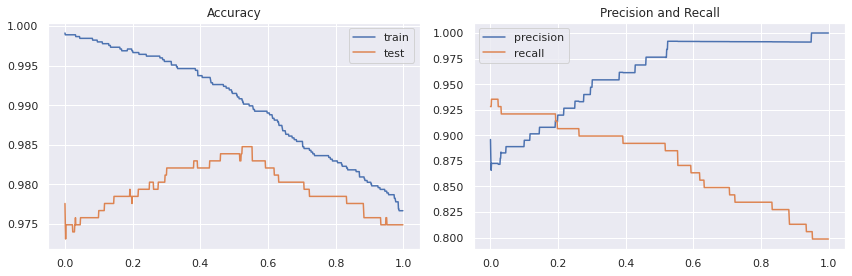

In [7]:
sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 2, 1)
sns.lineplot(alphas, train_acc, label = 'train')
sns.lineplot(alphas, test_acc, label = 'test')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(alphas, precision, label = 'precision')
sns.lineplot(alphas, recall, label = 'recall')
plt.title('Precision and Recall')
plt.tight_layout()

plt.show()

In [8]:
temp = np.matrix(np.c_[alphas, train_acc, test_acc, recall, precision])
nb_model_metrics = pd.DataFrame(data = temp, 
                      columns = ['alphas', 'Train Accuracy', 'Test Accuracy', 'Test Recall', 'Test Precision'])
nb_model_metrics.head()

,alphas,Train Accuracy,Test Accuracy,Test Recall,Test Precision
0,0.00001,0.999103,0.977578,0.928058,0.895833
1,0.00101,0.998878,0.974888,0.928058,0.877551
2,0.00201,0.998878,0.973094,0.928058,0.865772
3,0.00301,0.998878,0.974888,0.935252,0.872483
4,0.00401,0.998878,0.974888,0.935252,0.872483


## Chossing the best model according to precision and accuracy

In [9]:
idx = nb_model_metrics[nb_model_metrics['Test Precision'] == nb_model_metrics['Test Precision'].max()]['Test Accuracy'].idxmax()
nb_model = naive_bayes.MultinomialNB(alpha = alphas[idx])
nb_model.fit(X_train, y_train)
print(nb_model_metrics.iloc[idx, :])

alphas            0.949010
Train Accuracy    0.979134
Test Accuracy     0.975785
Test Recall       0.805755
Test Precision    1.000000
Name: 949, dtype: float64


## Confusion matrix

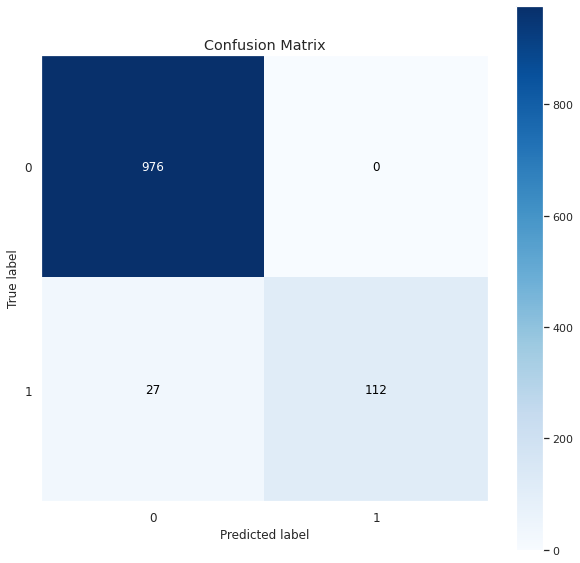

In [10]:
preds = nb_model.predict(X_test)

plt_con_mat(y_test, preds, figsize=(10,10))
plt.show()

# Support Vector Machine (SVM)

In [11]:
C_vals = np.arange(500, 2000, 100)
train_acc = []
test_acc = []
recall = []
precision = []

for C in C_vals:
    
    svc = svm.LinearSVC(C = C)
    svc.fit(X_train, y_train)
    
    train_acc.append(svc.score(X_train, y_train))
    test_acc.append(svc.score(X_test, y_test))
    recall.append(metrics.recall_score(y_test, svc.predict(X_test)))
    precision.append(metrics.precision_score(y_test, svc.predict(X_test)))

print("Training complete")

Training complete


## Model training performance

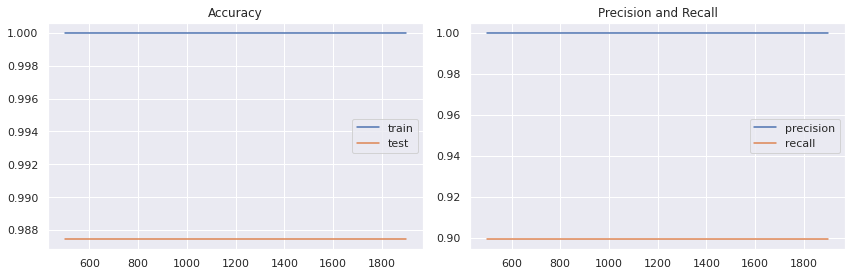

In [12]:
sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 2, 1)
sns.lineplot(C_vals, train_acc, label = 'train')
sns.lineplot(C_vals, test_acc, label = 'test')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(C_vals, precision, label = 'precision')
sns.lineplot(C_vals, recall, label = 'recall')
plt.title('Precision and Recall')
plt.tight_layout()

plt.show()

In [13]:
temp = np.matrix(np.c_[C_vals, train_acc, test_acc, recall, precision])
svm_model_metrics = pd.DataFrame(data = temp, 
                                 columns = ['C values', 'Train Accuracy', 'Test Accuracy', 'Test Recall', 'Test Precision'])
svm_model_metrics.head()

,C values,Train Accuracy,Test Accuracy,Test Recall,Test Precision
0,500.0,1.0,0.987444,0.899281,1.0
1,600.0,1.0,0.987444,0.899281,1.0
2,700.0,1.0,0.987444,0.899281,1.0
3,800.0,1.0,0.987444,0.899281,1.0
4,900.0,1.0,0.987444,0.899281,1.0


## Choosing the best model

In [14]:
idx = svm_model_metrics[svm_model_metrics['Test Precision'] == svm_model_metrics['Test Precision'].max()]['Test Accuracy'].idxmax()
svm_model = svm.LinearSVC(C = C_vals[idx])
svm_model.fit(X_train, y_train)
print(svm_model_metrics.iloc[idx, :])

C values          500.000000
Train Accuracy      1.000000
Test Accuracy       0.987444
Test Recall         0.899281
Test Precision      1.000000
Name: 0, dtype: float64


## Confusion Matrix

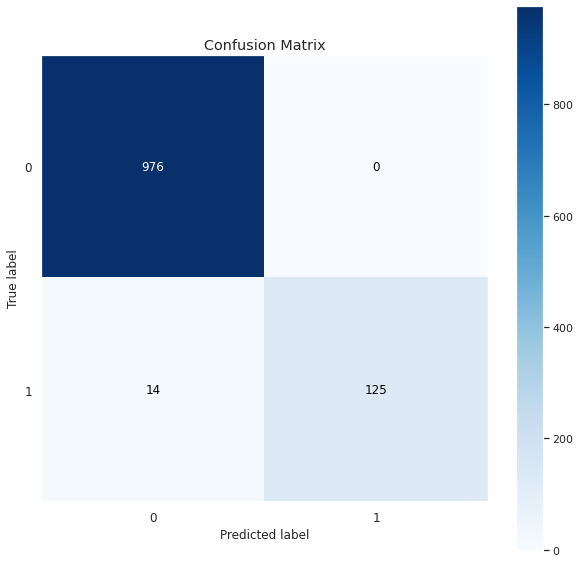

In [15]:
preds = svm_model.predict(X_test)

plt_con_mat(y_test, preds, figsize=(10,10))
plt.show()